# Optimización de limpieza

## Cargar el data_ar

In [ ]:
import pandas as pd

In [50]:
data_ar=pd.read_csv('../data/---datos limpios/data_ar.csv')

In [51]:
data_ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746365 entries, 0 to 746364
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               746365 non-null  object 
 1   ad_type          746365 non-null  object 
 2   start_date       746365 non-null  object 
 3   end_date         746365 non-null  object 
 4   created_on       746365 non-null  object 
 5   lat              655479 non-null  float64
 6   lon              655298 non-null  float64
 7   país             746365 non-null  object 
 8   provincia        746365 non-null  object 
 9   localidad        726248 non-null  object 
 10  rooms            497539 non-null  float64
 11  bedrooms         460054 non-null  float64
 12  bathrooms        554025 non-null  float64
 13  surface_total    302829 non-null  float64
 14  surface_covered  298210 non-null  float64
 15  price            716732 non-null  float64
 16  currency         715672 non-null  obje

In [52]:
data_ar.isnull().sum()

id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 90886
lon                 91067
país                    0
provincia               0
localidad           20117
rooms              248826
bedrooms           286311
bathrooms          192340
surface_total      443536
surface_covered    448155
price               29633
currency            30693
price_period       463447
title                   1
description            36
property_type           0
operation_type          0
dtype: int64

Son importantes los siguientes features, y tienen datos nulos:
* lat y lon
* rooms
* bedrooms
* bathrooms
* surface_total
* surface_covered
* property_type
* Ubicación: país-provincia-localidad
* currency

## Exploración: lat y lon

In [53]:
#corroborrar los tipos de dato de lat y lon
data_ar[['lat','lon']].dtypes

lat    float64
lon    float64
dtype: object

In [54]:
for col in ['lat', 'lon']:
    print(f"{col}: Total Filas = {len(data_ar)}, Valores Nulos = {data_ar[col].isnull().sum()}, Porcentaje = {data_ar[col].isnull().mean() * 100:.2f}%")

lat: Total Filas = 746365, Valores Nulos = 90886, Porcentaje = 12.18%
lon: Total Filas = 746365, Valores Nulos = 91067, Porcentaje = 12.20%


Conclusión: Se decidio no eliminar los datos nulos de [lat] [lon] ya que perderiamos más del 11% de los datos.

In [55]:
#ver el resumen estadistico de lat y lon
data_ar[['lat','lon']].describe()

,lat,lon
count,655479.000000,655298.000000
mean,-34.639429,-59.378255
std,2.212407,2.593049
min,-54.841256,-122.538399
25%,-34.771457,-58.810673
50%,-34.603859,-58.479369
75%,-34.435198,-58.387972
max,49.633731,8.386075


Insight: Podemos ver que tambien hay outliers

 Los rangos geográficos aproximados de latitud (lat) y longitud (lon):


| Región                      | Latitud (lat)       | Longitud (lon)      |
|----------------------------|---------------------|---------------------|
| Argentina entera         | -55 a -21.5           | -73.5 a -53.5           |
| Provincia de Buenos Aires | aprox -41.5 a -33.5     | -64.5 a -56.5           |
| CABA y GBA (AMBA)         | aprox -35.1 a -34.3   | -58.8 a -58.2       |

Entonces:

Se ve una latitud como 49.6 Está por el Europa(Canada)

Una longitud como 8.3 está en Europa (Alemania).

Y -122 está en el Pacífico (California, USA).



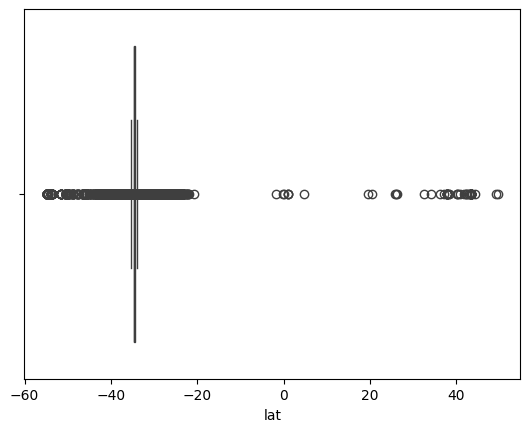

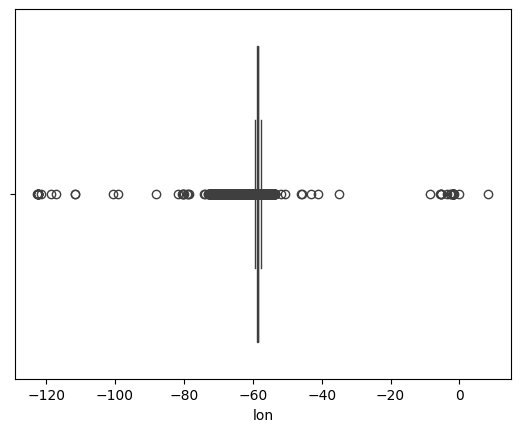

In [56]:
#visualización la distribución
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=data_ar['lat']) 
plt.show()

sns.boxplot(x=data_ar['lon']) 
plt.show()

Con estos graficos podemos seguir confirmando que nos encontramos con valores outliers.

¿Cuantas propiedades estan fuera de Argentina?


In [57]:
# Crear una copia del DataFrame original
df_clean = data_ar.copy()

#Rango de coordenadas válidas de Argentina
lat_val = df_clean['lat'].between(-55, -21.5)
lon_val = df_clean['lon'].between(-73.5, -53.5)

#Filtramos propiedades que tienen la lat y lon fuera de Argentina
lat_outliers= df_clean[~lat_val]
lon_outliers= df_clean[~lon_val]

#cantidad de outliers
print('Latitudes fuera de Argentina', len(lat_outliers))
print('Longitudes fuera de Argentina',len(lon_outliers))
                                  

Latitudes fuera de Argentina 90954
Longitudes fuera de Argentina 91141


Una estraegia para poder imputar lat y lon es usar localidad/barrio. Es decir, si a una propiedad le falta la coordenada, pero tengo el barrio, le pongo la latitud y longitud promedio de ese barrio. 

In [58]:
df_clean[['localidad']].isnull().sum()

localidad    20117
dtype: int64

La localidad tambien tiene datos faltantes, por lo tanto si queremos imputar lat y lon basandonos en él, se va a encontrar con datos nulos. 

In [59]:
#Unimos los datos con lat y lon raras y eliminamos los repetidos
outliers= pd.concat([lat_outliers, lon_outliers]).drop_duplicates()

outliers[['lat','lon','localidad']].head(10)

,lat,lon,localidad
6,NaN,NaN,Alvear
13,NaN,NaN,General Pueyrredón
15,NaN,NaN,Santa Clara del Mar
26,NaN,NaN,Pilar
27,NaN,NaN,Tigre
45,NaN,NaN,Palermo
85,NaN,NaN,Córdoba
86,NaN,NaN,Mar del Plata
90,NaN,NaN,Pinamar
91,NaN,NaN,Pinamar


Resumen:

Tenemos lat y lon:
Con valores nulos. Tambien con valores extremos(ouliers)que incluso no pertenecen a Argentina.

Queremos usar localidad para corregir esos casos, pero nos damos cuenta que tambien tiene valores nulos.

Estrategia:
Primero vamos a trabajar los outliers de la lat y lon que son incorrectos, ya que para sacar la mediana por barrio,nos va a distorcionar.

## Tratamiento outliers localidad

In [60]:
import numpy as np
# Reemplazamos las cordenadas que estan mal por NaN
df_clean.loc[~lat_val, 'lat'] = np.nan
df_clean.loc[~lon_val, 'lon'] = np.nan

In [61]:
#calculamos las medianas por barrio
medianas_loc= df_clean.groupby('localidad')[['lat','lon']].median()

print(medianas_loc)

                      lat        lon
localidad                           
9 de Julio     -28.779775 -61.666509
Abasto         -34.603890 -58.410998
Acceso Norte          NaN        NaN
Acebal         -33.242155 -60.834136
Achiras        -32.590662 -65.006580
...                   ...        ...
Zárate         -34.110579 -59.055408
orquincó       -41.702893 -70.049797
Álvarez        -33.141158 -60.715830
Ámbul          -31.516554 -65.064989
Ángel Gallardo -31.556414 -60.676246

[1271 rows x 2 columns]


Se imputa con mediana de los barrios calculados los coordenadas malas(que ahora son NaN)

In [62]:
# 1.Se establece el indice en 'localidad' para que sea más fácil cruzar con medianas_loc
df_clean.set_index("localidad", inplace=True)

# 2. Rellena los NaN de lat y lon con la mediana del barrio (según el índice actual)
df_clean[["lat", "lon"]] = df_clean[["lat", "lon"]].fillna(medianas_loc)

In [63]:
# 3. Devuelve 'localidad' a una columna normal (ya no como índice)
df_clean.reset_index(inplace=True)

In [64]:
df_clean.isnull().sum()

localidad           20117
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                  8386
lon                  8407
país                    0
provincia               0
rooms              248826
bedrooms           286311
bathrooms          192340
surface_total      443536
surface_covered    448155
price               29633
currency            30693
price_period       463447
title                   1
description            36
property_type           0
operation_type          0
dtype: int64

In [65]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746365 entries, 0 to 746364
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   localidad        726248 non-null  object 
 1   id               746365 non-null  object 
 2   ad_type          746365 non-null  object 
 3   start_date       746365 non-null  object 
 4   end_date         746365 non-null  object 
 5   created_on       746365 non-null  object 
 6   lat              737979 non-null  float64
 7   lon              737958 non-null  float64
 8   país             746365 non-null  object 
 9   provincia        746365 non-null  object 
 10  rooms            497539 non-null  float64
 11  bedrooms         460054 non-null  float64
 12  bathrooms        554025 non-null  float64
 13  surface_total    302829 non-null  float64
 14  surface_covered  298210 non-null  float64
 15  price            716732 non-null  float64
 16  currency         715672 non-null  obje

Sintesis: Se corrige las coordenadas incorrectas(outliers) usando la ubicación típica del barrio. 

Validación

In [66]:
# Verificamos nuevamente si hay coordenadas fuera de Argentina
lat_val = df_clean['lat'].between(-55, -21.5)
lon_val = df_clean['lon'].between(-73.5, -53.5)

print("Latitudes inválidas después de corregir:", df_clean[~lat_val].shape[0])
print("Longitudes inválidas después de corregir:", df_clean[~lon_val].shape[0])


Latitudes inválidas después de corregir: 8386
Longitudes inválidas después de corregir: 8407


Esas filas quedaron con NaN en lat o lon, incluso después de la imputación. Esas filas no se pueden imputar con la mediana del barrio, porque no sabemos a qué barrio pertenecen, por eso de eliminará.





In [70]:
# Filtrar registros donde las tres columnas son nulas
filtro = df_clean['lat'].isna() & df_clean['lon'].isna() & df_clean['localidad'].isna()

# Eliminar esos registros del DataFrame
df_clean = df_clean[~filtro]


## Tratamiento de datos Nan Localidad

In [71]:
df_clean.isnull().sum().head(10)

localidad     12297
id                0
ad_type           0
start_date        0
end_date          0
created_on        0
lat             566
lon             587
país              0
provincia         0
dtype: int64

¿Cuales son localidades nan con lat y lon presentes?

In [72]:
filtro_localidad_nula = df_clean['localidad'].isna()
print("Localidad nula + lat y lon presentes:" , df_clean[filtro_localidad_nula][['lat', 'lon']].notna().sum())

Localidad nula + lat y lon presentes: lat    12297
lon    12276
dtype: int64


De las 12.297 filas con localidad nula, la gran mayoría sí tienen lat y lon presentes:

lat: 12.297 no nulas

lon: 12.276 no nulas

Eso significa que esas coordenadas podrían ayudar a recuperar la localidad usando un proceso de geocodificación inversa.

## Geodificación inversa

El objetivo es rellenar las localidad faltantes con Geopy y Nominatim.

In [73]:
from geopy.geocoders import Nominatim
from time import sleep
import pandas as pd

In [74]:
# Inicializar Nominatim
geolocator = Nominatim(user_agent="mi-proyecto-inmobiliario")

# Función que intenta obtener la localidad
def obtener_localidad(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), language='es')
        if location and 'address' in location.raw:
            return (
                location.raw['address'].get('city') or
                location.raw['address'].get('town') or
                location.raw['address'].get('village')
            )
    except:
        return None

# Crear una copia 
df_temp = df_clean.copy()


Antes de realizar la consulta masiva en la API, quiero verificar si la API devuelve localidades correctas, seleccionamos una muestra pequeña de coordenadas.

In [75]:
coordenadas_unicas = df_temp[filtro][['lat', 'lon']].drop_duplicates()
print(coordenadas_unicas.head())

C:\Users\NB USER\AppData\Local\Temp\ipykernel_1432\4207051210.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coordenadas_unicas = df_temp[filtro][['lat', 'lon']].drop_duplicates()


Empty DataFrame
Columns: [lat, lon]
Index: []


In [76]:
# Tomar una muestra aleatoria de 20 coordenadas únicas
muestra_coords = coordenadas_unicas.sample(n=20, random_state=42)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
print("\nResultados de geocodificación inversa:")

for idx, row in muestra_coords.iterrows():
    lat = row['lat']
    lon = row['lon']
    localidad = obtener_localidad(lat, lon)  # función de consulta
    print(f"{lat}, {lon} => {localidad}")

-32.8756302, -68.7743767 => None
-32.86902712, -68.82555197 => Ciudad de Mendoza
-27.58162, -56.68231 => Municipio de Ituzaingó
-31.6549258, -60.7151476 => Santa Fe
-32.89971825, -68.82129777 => None
-31.5837620757, -64.3430353 => Villa Parque Santa Ana
-38.9824075394, -68.0716823799 => Neuquén
-32.913791, -68.820948 => None
-32.92921829, -60.81238937 => Funes
-40.818813, -65.104852 => Las Grutas
-31.635371, -60.7102089 => Santa Fe
-31.3997158, -64.199304 => Córdoba
-34.8911743894, -58.0398488045 => Manuel B. Gonnet
-38.942396687, -67.9694740074 => Cipolletti
-38.9237222, -68.055224 => Neuquén
-38.956423155, -68.0256842045 => Neuquén
-32.9988806, -58.5285025 => Límite de Ejido de Municipio de Gualeguaychú
-32.5066046, -64.9839084 => Cortaderas
-38.9423504, -68.0553348 => Neuquén
-38.9476149684, -68.047869878 => Neuquén


Verificación si una coordenada especifica tenía la localidad nula

In [ ]:
# Coordenadas que estás verificando
lat = -32.86902712
lon = -68.82555197

# Buscar el índice de la fila que tiene esas coordenadas
indice_fila = df_temp[(df_temp['lat'] == lat) & (df_temp['lon'] == lon)].index

# Verificar si la localidad estaba nula
if df_temp.loc[indice_fila, 'localidad'].isnull().any():
    print(f"La localidad para las coordenadas {lat}, {lon} estaba nula.")
else:
    print(f"La localidad para las coordenadas {lat}, {lon} ya estaba definida.")



La localidad para las coordenadas -32.86902712, -68.82555197 estaba nula.


In [ ]:
from tqdm import tqdm 
# Aplicar la función fila por fila
for idx in tqdm(df_temp[filtro].index):  # tqdm agrega una barra de progreso
    lat = df_temp.at[idx, 'lat']
    lon = df_temp.at[idx, 'lon']
    localidad = obtener_localidad(lat, lon)
    df_temp.at[idx, 'localidad'] = localidad
    sleep(1)  # para no saturar la API

100%|██████████| 12276/12276 [17:22:25<00:00,  5.09s/it]       


Verificación 

In [ ]:
df_temp['localidad'].isna().sum()


np.int64(1066)

Este número bajó respecto al original (12.297), entonces la API llenó gran parte de los valores.

In [ ]:
df_temp[['provincia','localidad','lat','lon']].sample(10)

,provincia,localidad,lat,lon
376346,Bs.As. G.B.A. Zona Norte,Pilar,-34.380712,-58.864379
742603,La Pampa,Santa Rosa,-36.629259,-64.280941
614024,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,-34.733563,-58.418734
145235,Misiones,Garupá,-27.520470,-55.852861
710059,Bs.As. G.B.A. Zona Oeste,Moreno,-34.643827,-58.790727
420587,Buenos Aires Costa Atlántica,Mar del Plata,-38.010451,-57.540242
587532,Capital Federal,Centro / Microcentro,-34.605589,-58.376780
20416,Bs.As. G.B.A. Zona Sur,Avellaneda,-34.682773,-58.369272
673456,Bs.As. G.B.A. Zona Oeste,Ituzaingó,-34.642236,-58.677239
598987,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,-34.788911,-58.419049


In [ ]:
import os

# Verificar si el archivo ya existe
file_path = '../data/---datos limpios/data_completa.csv'

#guardar el csv
if not os.path.exists(file_path):
    df_temp.to_csv(file_path, index= False)
    print('archivo guardado')
else:
    print('el archivo ya exisiste')

archivo guardado
